# Detecting outliers using the rolling mean and median

In this notebook we show how to identify and impute outliers in time series using the rolling mean and rolling median.

We will work with a monthly retail sales dataset (found [here](https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv)).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 1, in the folder "01-Datasets" from this repo.

## Data Set Synopsis

The timeseries is between January 1992 and Apr 2005.

It consists of a single series of monthly values representing sales volumes. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import STL

sns.set_context("talk")

# Identifying outliers

In this notebook an outlier is a particular observation which is considered to be very different to the rest of the data. We present various methods below which define "very different" in a quantitative way.  We care about identifying and understanding if there are outliers in our data because they can bias forecasting models resulting in poor forecasts.

For the purpose of pre-processing your data the first thing to do would be to plot your data and visually inspect for obvious outliers. Secondly, if you have a large number of time series or suspected outliers you may wish to identify them in an automated fashion. We demonstrate a range of methods below which can help to automatically identify outliers in time series data, further information about these methods can be found in this [paper [1]](https://arxiv.org/abs/2002.04236).

Once an outlier is identified there are a set of choices that can be made depending on the nature of the outlier:

1. Leave outliers in the dataset and try to use forecasting methods robust to outliers. 
2. Remove the outliers and impute them with more sensible values (e.g., using the estimation methods below or missing value imputation methods discussed in the previous lecture). This would be sensible if the outlier is known to be the result of a recording error or an event that is unlikely to repeat itself in the forecast window.
3. Model the outlier as a feature if the nature of the outlier is known. For example, an outlier due to a public holiday can be captured by a binary feature that is 1 on the public holiday and 0 otherwise. We shall show how to do this in the regression models section.

[1] Blázquez-García, Ane, et al. "A review on outlier/anomaly detection in time series data." arXiv preprint arXiv:2002.04236 (2020) 

# Load data

In [2]:
# Load retail sales dataset with the artificially added outliers
df = pd.read_csv(
    "../Datasets/example_retail_sales_with_outliers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

# Plot the data to visually inspect any outliers

Text(0.5, 0, 'Time')

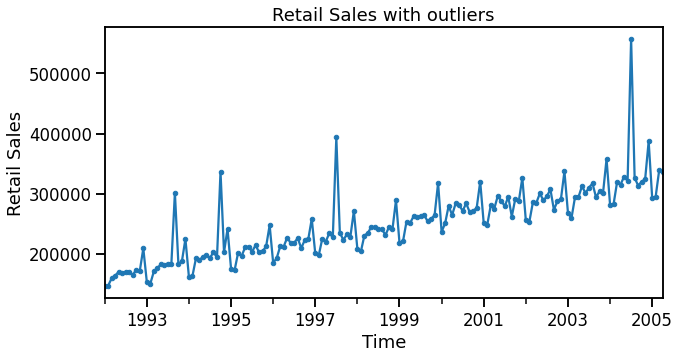

In [3]:
fig, ax = plt.subplots(figsize=[10, 5])
df.plot(y="y", marker=".", figsize=[10, 5], legend=None, ax=ax)
ax.set_title("Retail Sales with outliers")
ax.set_ylabel("Retail Sales")
ax.set_xlabel("Time")

The seasonal spikes in the data are likely to be picked up as outliers. We shall de-seasonalise the data first using STL decomposition as shown in the previous notebook. 

# De-seasonalise data

A large value for the `seasonal` parameter is chosen for the STL decomposition, this is based on an assumption that the seasonality is not changing very much. In addition we set the `robust` parameter to True which implements an outlier robust version of STL decomposition.

In [4]:
# Apply STL decomposition
res = STL(df["y"], robust=True).fit()
seasonal_component = res.seasonal
seasonal_component.head()

ds
1992-01-01   -18117.495889
1992-02-01   -19115.124261
1992-03-01    -5472.704639
1992-04-01     -934.499381
1992-05-01     2910.868481
Name: season, dtype: float64

In [5]:
df_deseasoned = (df["y"] - seasonal_component).to_frame("y")

In [6]:
df_deseasoned.head()

,y
ds,
1992-01-01,164493.495889
1992-02-01,166194.124261
1992-03-01,164808.704639
1992-04-01,164603.499381
1992-05-01,167157.131519


Text(0.5, 0, 'Time')

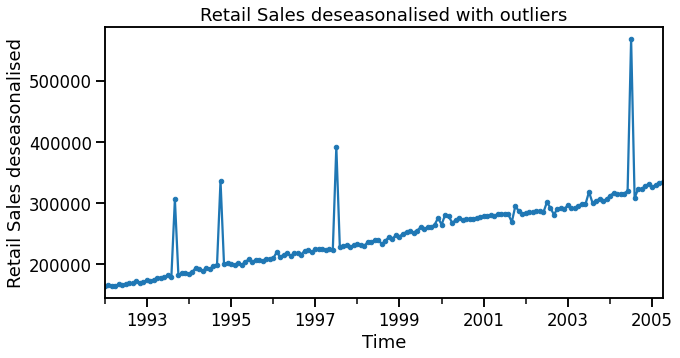

In [7]:
fig, ax = plt.subplots(figsize=[10, 5])

df_deseasoned.plot(y="y", marker=".", figsize=[10, 5], legend=None, ax=ax)
ax.set_title("Retail Sales deseasonalised with outliers")
ax.set_ylabel("Retail Sales deseasonalised")
ax.set_xlabel("Time")

# Estimation methods

In this section we implement methods which identify outliers using the following criteria: an observation is an outlier if it deviates significantly from an expected value. This can be expressed as:

$$|y_t - \hat{y}_t| > \delta$$

where $y_t$ is the observation at time $t$, $\hat{y}_t$ is the expected value at time $t$, and $\delta$ is a user specified threshold or can be calculated from the data and change with time depending on the method. Estimation methods use values both before and after the time point $t$ to calculate $\hat{y}_t$. 

We now show how to use the rolling mean and rolling median to compute an expcted value $\hat{y}_t$ and heuristics to setting a threshold $\delta$.

# Rolling mean

The expected value $\hat{y}_t$ is computed by taking a windowed mean of the observations around $t$:

$$\hat{y}_t = mean({y_{t-T}, ..., y_{t-1}, y_{t}, y_{t+1}, ..., y_{t+T}})$$

where the window is of size $2T+1$.

The threshold is typically some number of the windowed standard deviation:

$$\delta_t = \alpha \times std({y_{t-T}, ..., y_{t-1}, y_{t}, y_{t+1}, ..., y_{t+T}})$$

$\alpha=3$ is a typical choice, however this can be adjusted depending on how sensitive you want the outlier detection to be.

In [8]:
df_ = df_deseasoned.copy()

In [9]:
# Compute yhat using a rolling mean and the rolling standard deviation which will be used as
# part of the threshold
df_rolling_stats = (
    df_["y"]
    .rolling(
        window=12,  # A window of 12 is chosen to average over yearly seasonality
        center=True,  # Use a centered window for the mean
        min_periods=1,
    )  # Min periods set to 1 so that edge cases also have estimates
    .agg({"rolling_mean": "mean", "rolling_std": "std"})
)


df_[["rolling_mean", "rolling_std"]] = df_rolling_stats

# Apply the threshold criteria to identify an outlier
factor = 3
df_["is_outlier"] = np.abs(df_["y"] - df_["rolling_mean"]) > factor * df_["rolling_std"]

df_.head()

,y,rolling_mean,rolling_std,is_outlier
ds,,,,
1992-01-01,164493.495889,165622.552337,1130.452750,False
1992-02-01,166194.124261,165890.339378,1251.760952,False
1992-03-01,164808.704639,166261.547409,1563.785489,False
1992-04-01,164603.499381,166537.395234,1680.647235,False
1992-05-01,167157.131519,167101.829539,2386.753924,False


Let's plot the results

Text(0.5, 0, 'Time')

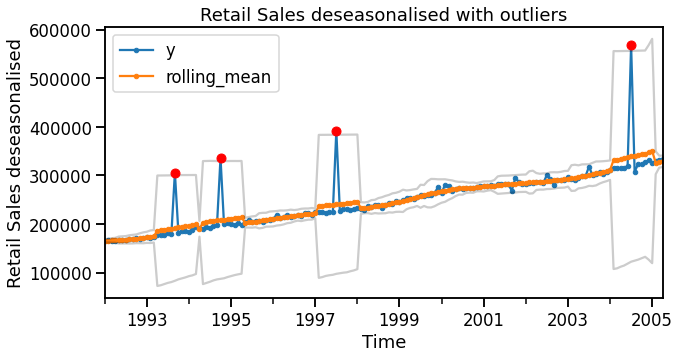

In [10]:
# Compute the upper and lower boundary of the threshold for plotting
df_["upper"] = df_["rolling_mean"] + factor * df_["rolling_std"]
df_["lower"] = df_["rolling_mean"] - factor * df_["rolling_std"]

# Plot
fig, ax = plt.subplots(figsize=[10, 5])
df_.plot(y=["y", "rolling_mean"], marker=".", ax=ax)
df_.plot(
    y=["upper", "lower"], figsize=[10, 5], ax=ax, color="k", alpha=0.2, legend=None
)

# If any data points are identified as outlier, plot them
if df_["is_outlier"].any():
    df_["y"].loc[df_["is_outlier"]].plot(
        marker="o", color="r", ax=ax, legend=None, linestyle=""
    )
    
ax.set_title("Retail Sales deseasonalised with outliers")
ax.set_ylabel("Retail Sales deseasonalised")
ax.set_xlabel("Time")

The outliers were only just identified. The rolling mean and rolling standard deviation change significantly when the window includes the outliers (see the jumps in the rolling mean and in the thresholds shown by the grey lines).  See this for yourself by adjusting the `window` parameter between small and large values. This shows that this method is not robust to outliers.

To overcome this we will introduce the rolling median method.

# Rolling median

## The Median Absolute Deviation

The median can be used instead of the mean to provide an outlier robust value for the expected value $\hat{y}_t$. However, we require an outlier robust estimator of the dispersion of a dataset to take the place of the standard deviation. The median absolute deviation, $MAD$, is an outlier robust estimator of the dispersion of a dataset. The $MAD$ is defined as:
$$ MAD = median(|y - median(y)|) $$

We write a helper function below to compute the $MAD$ using Numpy:

In [11]:
median_absolute_deviation = lambda y: np.median(np.abs(y - np.median(y)))

In [12]:
# Example with an outlier
data_with_outlier = [1, 1, 1, 2, 2, 2, 1e6]

print(f"Dataset: {data_with_outlier}")
print(f"Median: {np.median(data_with_outlier)}")
print(f"Median absolute deviation: {median_absolute_deviation(data_with_outlier)}")
print(f"Mean: {np.mean(data_with_outlier)}")
print(f"Standard deviation: {np.std(data_with_outlier)}")

Dataset: [1, 1, 1, 2, 2, 2, 1000000.0]
Median: 2.0
Median absolute deviation: 1.0
Mean: 142858.42857142858
Standard deviation: 349926.5812215296


As you can see, the median and MAD are robust to outliers whereas the mean and standard deviation are not.

## Identifying outliers

For this method, the expected value $\hat{y}_t$ is computed by taking a windowed median of the observations around $t$:

$$\hat{y}_t = median({y_{t-T}, ..., y_{t-1}, y_{t}, y_{t+1}, ..., y_{t+T}})$$

where the window is of size $2T+1$.

The threshold is typically some number of the windowed $MAD$:

$$\delta_t = \alpha \times MAD({y_{t-T}, ..., y_{t-1}, y_{t}, y_{t+1}, ..., y_{t+T}})$$

$\alpha=3.5$ is a recommended choice [2], however this can be adjusted depending on how sensitive you want the outlier detection to be.

[2] Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and Handle Outliers", The ASQC Basic References in Quality Control: Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.

In [13]:
df_ = df_deseasoned.copy()

In [14]:
df_rolling_stats = (
    df_["y"]
    .rolling(
        window=12,  # A window of 12 is chosen to average over yearly seasonality
        center=True,  # Use a centered window for the mean
        min_periods=1,
    )  # Min periods set to 1 so that edge cases also have estimates
    .agg({"rolling_median": "median", "rolling_MAD": median_absolute_deviation})
)

df_[["rolling_median", "rolling_MAD"]] = df_rolling_stats

# Apply the threshold criteria to identify an outlier
factor = 3.5
df_["is_outlier"] = (
    np.abs(df_["y"] - df_["rolling_median"]) > factor * df_["rolling_MAD"]
)

df_.head()

,y,rolling_median,rolling_MAD,is_outlier
ds,,,,
1992-01-01,164493.495889,165501.414450,937.429476,False
1992-02-01,166194.124261,166194.124261,1302.937367,False
1992-03-01,164808.704639,166336.241297,1344.178495,False
1992-04-01,164603.499381,166478.358333,1669.653694,False
1992-05-01,167157.131519,166817.744926,1967.736600,False


Text(0.5, 0, 'Time')

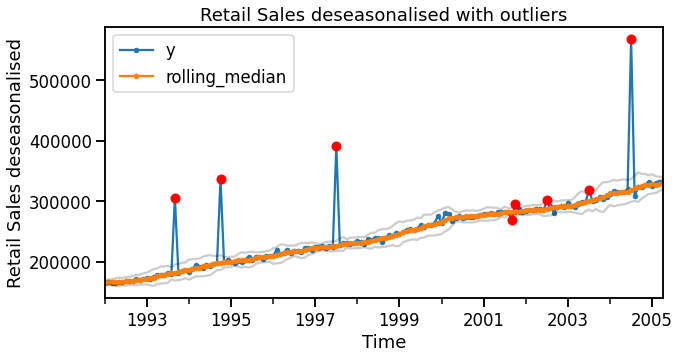

In [15]:
# Compute the upper and lower boundary of the threshold for plotting
df_["upper"] = df_["rolling_median"] + factor * df_["rolling_MAD"]
df_["lower"] = df_["rolling_median"] - factor * df_["rolling_MAD"]

# Plot
fig, ax = plt.subplots(figsize=[10, 5])
df_.plot(y=["y", "rolling_median"], marker=".", ax=ax)
df_.plot(
    y=["upper", "lower"], figsize=[10, 5], ax=ax, color="k", alpha=0.2, legend=None
)

# If any data points are identified as outliers, plot them
if df_["is_outlier"].any():
    df_["y"].loc[df_["is_outlier"]].plot(
        marker="o", color="r", ax=ax, legend=None, linestyle=""
    )
    
ax.set_title("Retail Sales deseasonalised with outliers")
ax.set_ylabel("Retail Sales deseasonalised")
ax.set_xlabel("Time")

As we can see the median and the MAD are more robust to outliers, there is not sudden change in the rolling median or MAD. We note both the MAD and the standard deviation will be proportional to the steepness of the trend. So the method may be more sensitive in areas with flatter trend: as we can see a smaller fluctuation in the data is identified as an outlier. A simple solution here would be to adjust the threshold. See this for yourself by increasing the `factor` variable above.

# Removing the outliers

Once the outliers are identified and a choice is made to remove them they can be imputed using the missing value methods we introduced in the previous section of the course, or using the values from the estimation methods introduced in this notebook. 

As an example we shall use linear interpolation.

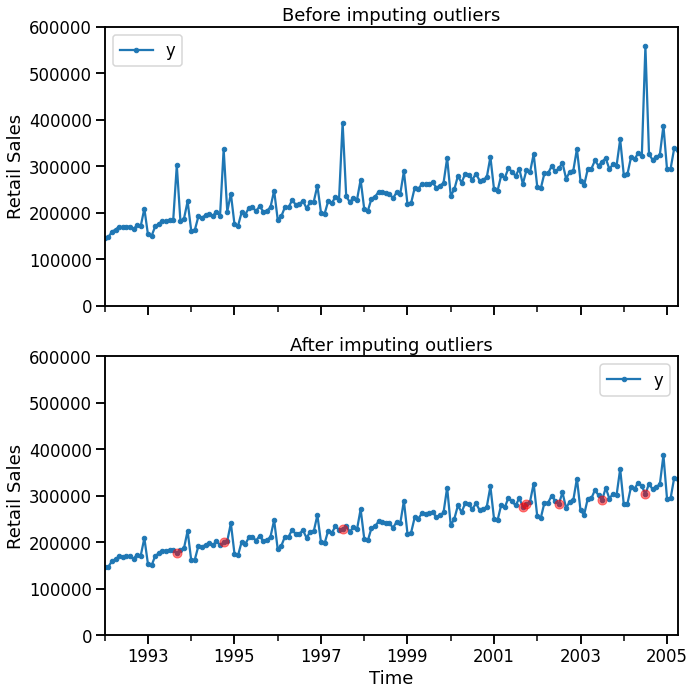

In [16]:
# Set outliers to NaN
df_.loc[df_["is_outlier"], "y"] = np.NaN

# Apply linear interpolation
df_.interpolate(method="linear", inplace=True)

# Add the seasonality extracted from STL back to deseaoned data
df_["y"] = df_["y"] + res.seasonal

# Plot the data and location of the identified outliers from the rolling median method
fig, ax = plt.subplots(nrows=2, figsize=[10, 10], sharex=True)
df.plot(y="y", marker=".", title="Before imputing outliers", ax=ax[0])
df_.plot(y=["y"], marker=".", title="After imputing outliers", ax=ax[1])
df_[df_["is_outlier"]]["y"].plot(
    marker="o", color="r", ax=ax[1], legend=None, linestyle="", alpha=0.5
)

ax[1].set_ylabel("Retail Sales")
ax[0].set_ylabel("Retail Sales")
ax[1].set_xlabel("Time")
ax[0].set_ylim([0, 600000])
ax[1].set_ylim([0, 600000])
plt.tight_layout()